In [1]:
!pip install optuna

#### Importamos librerias

In [2]:
import pandas as pd
import xgboost as xgb
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import unicodedata
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_score, recall_score

#### Activamos visualización max columns/rows

In [3]:
# Para mostrar tanto todas las columnas como todos los registros
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Leemos el dataset

In [4]:
# Ruta completa del archivo CSV
ruta_archivo = 'data/processed_csv/df_model_final.csv'

# Leer el archivo CSV en un DataFrame
df_model_final = pd.read_csv(ruta_archivo)

#### Guardamos el Scaler

In [5]:
# Entrenar y transformar el scaler
scaler = MinMaxScaler().fit(df_model_final[['good_qty', 'theorical_time']])

# Guardar el scaler en un archivo
with open('scaler.pickle', 'wb') as file:
    pickle.dump(scaler, file)

#### Calculamos el achieve performance (TARGET)

In [6]:
# Corte rendimiento aceptable
performance_cutoff = 0.80

df_model_final['achieve_performance'] = df_model_final['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

#### Separamos el dataset en Train/Test & Validation

In [7]:
# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
df_model_final_2023 = df_model_final[df_model_final['year'] == 2023].copy()
df_model_final_2023.reset_index(inplace=True, drop=True)
df_model_final_not_2023 = df_model_final[df_model_final['year'] != 2023].copy()
df_model_final_not_2023.reset_index(inplace=True, drop=True)

#### Separamos las FEATURES y TARGET

In [8]:
df = df_model_final_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

#### Cargamos el Scaler

In [9]:
scaler_path = '/home/pau-mila/UIC/05 - TFM - Fluidra/Fluidra-DS-Project/scaler.pkl' 

# Cargar el scaler desde un archivo
with open(scaler_path, 'rb') as file:
    scaler = pickle.load(file)

/home/pau-mila/miniconda3/envs/fluidra_poetry/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


#### Tratamiento de los datos

In [10]:
# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']


#### Separar Train/Test

In [11]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.2, random_state=42)

#### Entrenar modelo con datos por defecto

In [12]:
# Crear el clasificador XGBoost con los mejores hiperparámetros
model = xgb.XGBClassifier(random_state= 42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train, verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

#### Predicciones

In [13]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

#### Resultados

In [14]:
# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))

# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))

# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 80.31%
Precisión del modelo: 83.68%
Recall del modelo: 91.04%


#### Confusion Matrix

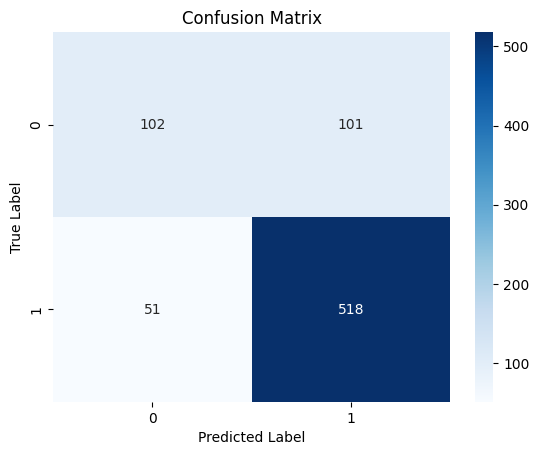

In [15]:
df_result_complete = pd.concat([result, df_model_final_not_2023[df_model_final_not_2023.index.isin(result.index)].loc[:, ~df_model_final_not_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Probar cambiando el corte de la performance

#### Corte 85%

In [16]:
data = df_model_final.copy()

# Corte rendimiento aceptable
performance_cutoff = 0.85

data['achieve_performance'] = data['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
data_2023 = data[data['year'] == 2023].copy()
data_2023.reset_index(inplace=True, drop=True)
data_not_2023 = data[data['year'] != 2023].copy()
data_not_2023.reset_index(inplace=True, drop=True)

df = data_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.2, random_state=42)

# Crear el clasificador XGBoost con los mejores hiperparámetros
model = xgb.XGBClassifier(random_state= 42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))

# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))

# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 76.68%
Precisión del modelo: 79.22%
Recall del modelo: 86.26%


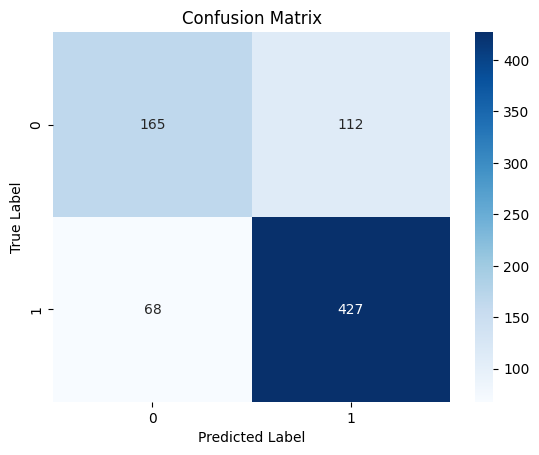

In [17]:
df_result_complete = pd.concat([result, data_not_2023[data_not_2023.index.isin(result.index)].loc[:, ~data_not_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### Corte 90%

In [18]:
data = df_model_final.copy()

# Corte rendimiento aceptable
performance_cutoff = 0.90

data['achieve_performance'] = data['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
data_2023 = data[data['year'] == 2023].copy()
data_2023.reset_index(inplace=True, drop=True)
data_not_2023 = data[data['year'] != 2023].copy()
data_not_2023.reset_index(inplace=True, drop=True)

df = data_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.2, random_state=42)

# Crear el clasificador XGBoost con los mejores hiperparámetros
model = xgb.XGBClassifier(random_state= 42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))

# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))

# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 71.11%
Precisión del modelo: 68.97%
Recall del modelo: 78.63%


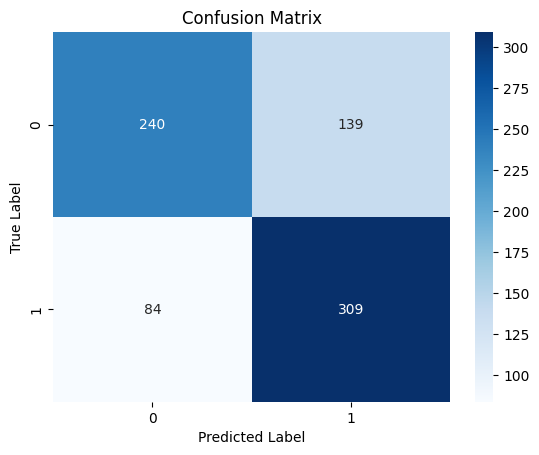

In [19]:
df_result_complete = pd.concat([result, data_not_2023[data_not_2023.index.isin(result.index)].loc[:, ~data_not_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### Corte 95%

In [20]:
data = df_model_final.copy()

# Corte rendimiento aceptable
performance_cutoff = 0.95

data['achieve_performance'] = data['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
data_2023 = data[data['year'] == 2023].copy()
data_2023.reset_index(inplace=True, drop=True)
data_not_2023 = data[data['year'] != 2023].copy()
data_not_2023.reset_index(inplace=True, drop=True)

df = data_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.2, random_state=42)

# Crear el clasificador XGBoost con los mejores hiperparámetros
model = xgb.XGBClassifier(random_state= 42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))

# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))

# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 68.91%
Precisión del modelo: 57.35%
Recall del modelo: 55.71%


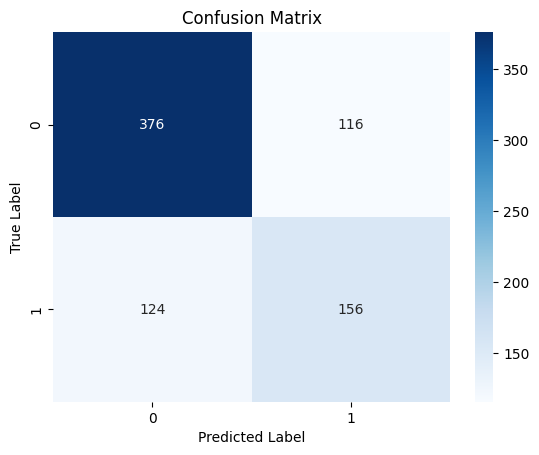

In [21]:
df_result_complete = pd.concat([result, data_not_2023[data_not_2023.index.isin(result.index)].loc[:, ~data_not_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Como podemos observar, cuanto mas alto ponemos el corte mas valores tenemos como no aceptados pero los resultados empeoran mucho. Es decir, bajamos mucho el accuracy junto con la precision y recall.

Por lo que, no creemos que una buena solución sea modificar el corte. A parte, creemos que un 80% era el corte correcto según lo que el Cliente queria y los resultados del EDA.

## Probar de modificar el threshold del xgboost

#### Creamos una clase para poder modificar el threshold

In [22]:
class CustomXGBClassifier:
    def __init__(self, threshold=0.5, **kwargs):
        self.threshold = threshold
        self.model = xgb.XGBClassifier(**kwargs)
    
    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
    
    def predict(self, X):
        proba_pred = self.model.predict_proba(X)
        predicciones_ajustadas = (proba_pred[:, 1] >= self.threshold).astype(int)
        return predicciones_ajustadas
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)


#### Probamos con un threshold del 51% para ver afectación

In [23]:
data = df_model_final.copy()

# Corte rendimiento aceptable
performance_cutoff = 0.80

data['achieve_performance'] = data['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
data_2023 = data[data['year'] == 2023].copy()
data_2023.reset_index(inplace=True, drop=True)
data_not_2023 = data[data['year'] != 2023].copy()
data_not_2023.reset_index(inplace=True, drop=True)

df = data_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.2, random_state=42)

# Crear el clasificador XGBoost con los mejores hiperparámetros
model = CustomXGBClassifier(threshold=0.51, random_state= 42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))
# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))
# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 81.09%
Precisión del modelo: 84.50%
Recall del modelo: 91.04%


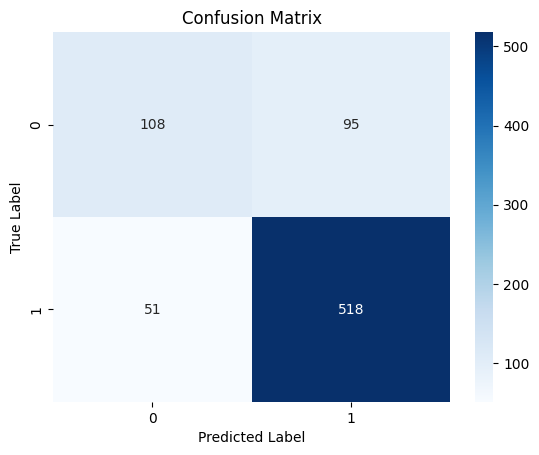

In [24]:
df_result_complete = pd.concat([result, data_not_2023[data_not_2023.index.isin(result.index)].loc[:, ~data_not_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Observamos como pasando del 50 al 51% mejora el modelo. Vamos a realizar mas prueba con saltos mas grandes para poder ver el comportamiento de cambiar el threshold

#### Threshold 60%

In [25]:
data = df_model_final.copy()

# Corte rendimiento aceptable
performance_cutoff = 0.80

data['achieve_performance'] = data['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
data_2023 = data[data['year'] == 2023].copy()
data_2023.reset_index(inplace=True, drop=True)
data_not_2023 = data[data['year'] != 2023].copy()
data_not_2023.reset_index(inplace=True, drop=True)

df = data_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.2, random_state=42)

# Crear el clasificador XGBoost con los mejores hiperparámetros
model = CustomXGBClassifier(threshold=0.6, random_state= 42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))
# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))
# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 79.92%
Precisión del modelo: 85.69%
Recall del modelo: 87.35%


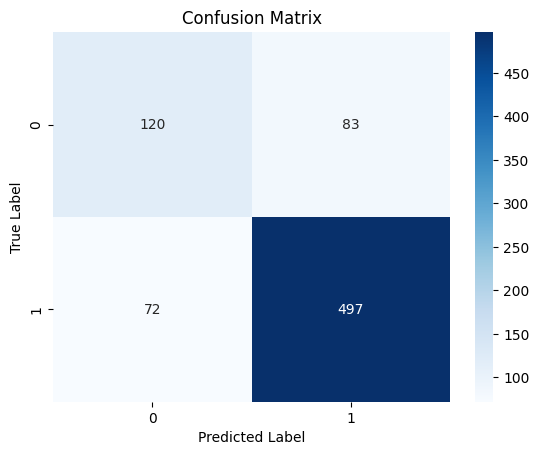

In [26]:
df_result_complete = pd.concat([result, data_not_2023[data_not_2023.index.isin(result.index)].loc[:, ~data_not_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Observamos que al poner un threshold de 60% o superior, empieza a bajar la accuracy junto a la precisión/recall.

Vamos aprobar, de aumentar poco a poco a ver si conseguimos encontrar un threshold suficientemente bueno para dejar el modelo así.

#### Threshold X

In [27]:
data = df_model_final.copy()

# Corte rendimiento aceptable
performance_cutoff = 0.80

data['achieve_performance'] = data['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
data_2023 = data[data['year'] == 2023].copy()
data_2023.reset_index(inplace=True, drop=True)
data_not_2023 = data[data['year'] != 2023].copy()
data_not_2023.reset_index(inplace=True, drop=True)

df = data_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.2, random_state=42)

# Crear el clasificador XGBoost con los mejores hiperparámetros
model = CustomXGBClassifier(threshold=0.51, random_state= 42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))
# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))
# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 81.09%
Precisión del modelo: 84.50%
Recall del modelo: 91.04%


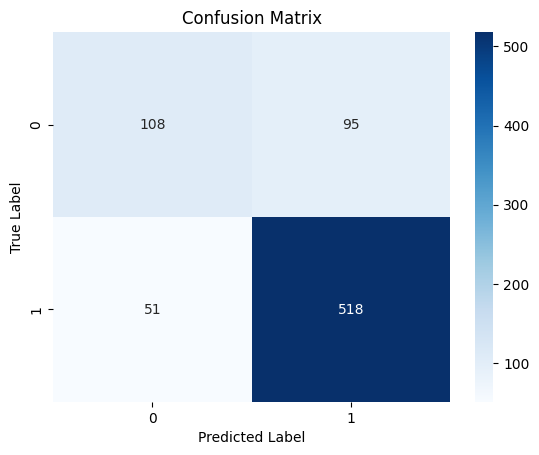

In [28]:
df_result_complete = pd.concat([result, data_not_2023[data_not_2023.index.isin(result.index)].loc[:, ~data_not_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Podemos ver como el valor óptimo en nuestro caso es un threshold del 51%. Si subimos o bajamos empeoramos el accuracy aunque podemos conseguir un mejor recall. Pero,no nos interesa ya que perdemos bastante accuracy en el modelo.

Vamos a probar ahora con este thresold de mover el corte de la performance a ver si tiene influencia.

In [29]:
data = df_model_final.copy()

# Corte rendimiento aceptable
performance_cutoff = 0.5

data['achieve_performance'] = data['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
data_2023 = data[data['year'] == 2023].copy()
data_2023.reset_index(inplace=True, drop=True)
data_not_2023 = data[data['year'] != 2023].copy()
data_not_2023.reset_index(inplace=True, drop=True)

df = data_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.2, random_state=42)

# Crear el clasificador XGBoost con los mejores hiperparámetros
model = CustomXGBClassifier(threshold=0.51, random_state= 42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))
# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))
# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 96.24%
Precisión del modelo: 97.99%
Recall del modelo: 98.12%


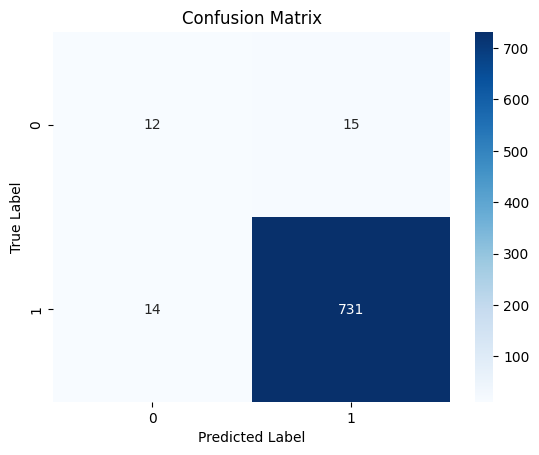

In [30]:
df_result_complete = pd.concat([result, data_not_2023[data_not_2023.index.isin(result.index)].loc[:, ~data_not_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Si bajamos mucho el corte de performance, mejoramos mucho el modelo pero basicamente porque siempre decimos que la combinación es buena. A si que en principio no podemos suponer esta opción. Miramos de una vez bajado un poco que pasa si subimos el corte

Finalmente nos quedamos con un corte del 80% y un threshold del 51%. No tiene sentido mover el corte ya que es unos de los objetivos del Cliente a parte de que podriamos estar engañando al modelo.

Vamos a comprobar los resultados finales y despues quitaremos el escalado para ver cuando bajamos para poder hacer feature engineering y comprobar sobre ese resultado sin escalado y despues ya lo escalariamos todo.

#### Resultado final

In [31]:
data = df_model_final.copy()

# Corte rendimiento aceptable
performance_cutoff = 0.8

data['achieve_performance'] = data['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
data_2023 = data[data['year'] == 2023].copy()
data_2023.reset_index(inplace=True, drop=True)
data_not_2023 = data[data['year'] != 2023].copy()
data_not_2023.reset_index(inplace=True, drop=True)

df = data_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.2, random_state=42)

# Crear el clasificador XGBoost con los mejores hiperparámetros
model = CustomXGBClassifier(threshold=0.51, random_state= 42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))
# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))
# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 81.09%
Precisión del modelo: 84.50%
Recall del modelo: 91.04%


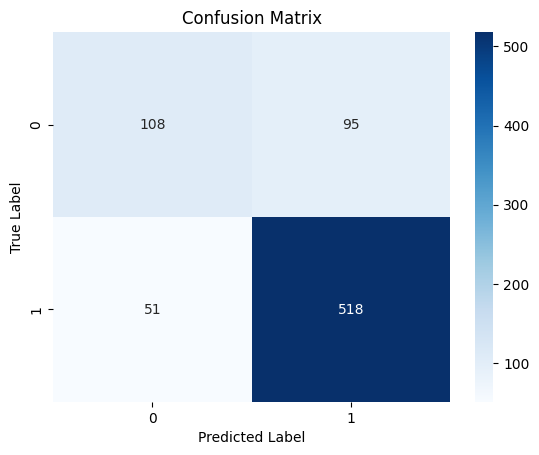

In [32]:
df_result_complete = pd.concat([result, data_not_2023[data_not_2023.index.isin(result.index)].loc[:, ~data_not_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Vamos a validar los resultados a ver si no hay un problema, al realizar estas modificaciones de threshold y corte

#### Validación con datos de 2023

In [33]:
df = data_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X_2023 = df[FEATURES]
y_2023 = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded_2023 = pd.get_dummies(X_2023)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled_2023 = pd.DataFrame(scaler.fit_transform(X_encoded_2023[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled_2023 = pd.concat([df_scaled_2023, X_encoded_2023], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled_2023 = X_encoded_scaled_2023.drop(columns=['good_qty', 'theorical_time'])

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled_2023['grupo_qty'] = pd.cut(X_encoded_scaled_2023['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled_2023 = pd.get_dummies(X_encoded_scaled_2023, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled_2023['time_of'] = X_encoded_scaled_2023['good_qty_scaled'] * X_encoded_scaled_2023['theorical_time_scaled']

In [34]:
X_encoded_scaled_2023.insert(114, 'grupo_qty_3', 0)
X_encoded_scaled_2023.insert(121, 'weekday_5', 0)
X_encoded_scaled_2023.insert(122, 'weekday_6', 0)
X_encoded_scaled_2023.insert(125, 'month_3', 0)
X_encoded_scaled_2023.insert(126, 'month_4', 0)
X_encoded_scaled_2023.insert(127, 'month_5', 0)
X_encoded_scaled_2023.insert(128, 'month_6', 0)
X_encoded_scaled_2023.insert(129, 'month_7', 0)
X_encoded_scaled_2023.insert(130, 'month_8', 0)
X_encoded_scaled_2023.insert(131, 'month_9', 0)
X_encoded_scaled_2023.insert(132, 'month_10', 0)
X_encoded_scaled_2023.insert(133, 'month_11', 0)
X_encoded_scaled_2023.insert(134, 'month_12', 0)

In [35]:
# Realizar predicciones en el conjunto de prueba
y_pred_2023 = model.predict(X_encoded_scaled_2023)
y_pred_proba_2023 = model.predict_proba(X_encoded_scaled_2023)[:, 1]

result = X_encoded_scaled_2023.copy()
result['prediction'] = y_pred_2023
result['prediction_prob'] = y_pred_proba_2023

# Calcular la precisión del modelo
accuracy = accuracy_score(y_2023, y_pred_2023)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))
# Calcular la precisión
precision = precision_score(y_2023, y_pred_2023)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))
# Calcular el recall
recall = recall_score(y_2023, y_pred_2023)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 80.33%
Precisión del modelo: 87.23%
Recall del modelo: 87.23%


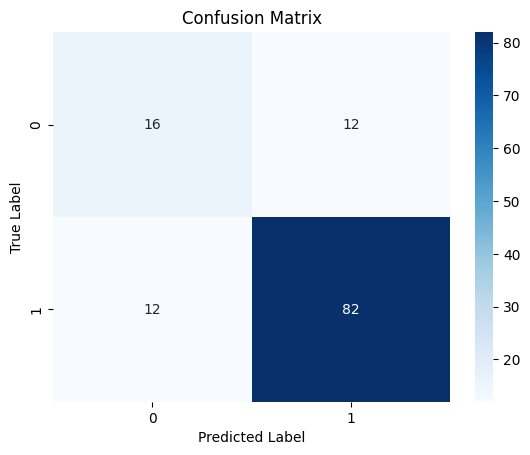

In [36]:
df_result_complete = pd.concat([result, data_2023[data_2023.index.isin(result.index)].loc[:, ~data_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### Resultado sin escalado

Resultados con el escalado:

- Precisión del modelo: 81.09%
- Precisión del modelo: 84.50%
- Recall del modelo: 91.04%

In [37]:
data = df_model_final.copy()

# Corte rendimiento aceptable
performance_cutoff = 0.8

data['achieve_performance'] = data['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
data_2023 = data[data['year'] == 2023].copy()
data_2023.reset_index(inplace=True, drop=True)
data_not_2023 = data[data['year'] != 2023].copy()
data_not_2023.reset_index(inplace=True, drop=True)

df = data_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Calcular los percentiles de la columna "good_qty"
percentiles = X_encoded['good_qty'].quantile([0.2, 0.4, 0.6])

# Crear las cuatro nuevas columnas en el dataframe
X_encoded['grupo_qty_1'] = X_encoded['good_qty'].apply(lambda x: 1 if x <= percentiles[0.2] else 0)
X_encoded['grupo_qty_2'] = X_encoded['good_qty'].apply(lambda x: 1 if percentiles[0.2] < x <= percentiles[0.4] else 0)
X_encoded['grupo_qty_3'] = X_encoded['good_qty'].apply(lambda x: 1 if percentiles[0.4] < x <= percentiles[0.6] else 0)
X_encoded['grupo_qty_4'] = X_encoded['good_qty'].apply(lambda x: 1 if x > percentiles[0.6] else 0)

# Aplicar el one-hot encoding a la columna de grupos
X_encoded = pd.get_dummies(X_encoded, columns=['weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded['time_of'] = X_encoded['good_qty'] * X_encoded['theorical_time']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Crear el clasificador XGBoost con los mejores hiperparámetros
model = CustomXGBClassifier(threshold=0.51, random_state= 42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))
# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))
# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 81.22%
Precisión del modelo: 84.64%
Recall del modelo: 91.04%


Finalmente no usamos el grupo por cantidad de bombas ya que parece que no mejora o directamente empeora el model:

#### Crear las cuatro nuevas columnas en el dataframe
- X_encoded['grupo_th_1'] = X_encoded['theorical_time'].apply(lambda x: 1 if x <= 31 else 0)
- X_encoded['grupo_th_2'] = X_encoded['theorical_time'].apply(lambda x: 1 if 10.5 < x <= 31 else 0)
- X_encoded['grupo_th_3'] = X_encoded['theorical_time'].apply(lambda x: 1 if x > 31 else 0)

Probamos de crear una columna para la estación y observamos que no funciona correctamente:

#### Estaciones del año
- X_encoded['invierno'] = X_encoded['month'].apply(lambda x: 1 if x in [1, 2, 12] else 0)
- X_encoded['primavera'] = X_encoded['month'].apply(lambda x: 1 if x in [3, 4, 5] else 0)
- X_encoded['verano'] = X_encoded['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
- X_encoded['otoño'] = X_encoded['month'].apply(lambda x: 1 if x in [9, 10, 11] else 0)

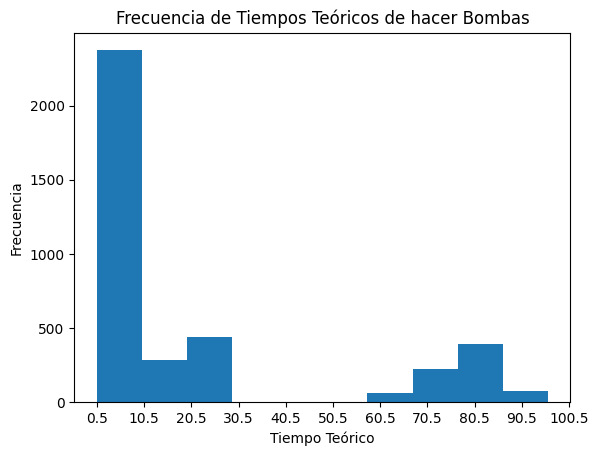

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener la columna de tiempos teóricos
tiempos_teoricos = df['theorical_time']

# Crear el gráfico de barras
plt.hist(tiempos_teoricos, bins=10)  # Puedes ajustar el número de bins según tus necesidades

# Establecer etiquetas y título del gráfico
plt.xlabel('Tiempo Teórico')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Tiempos Teóricos de hacer Bombas')

# Ajustar el rango y las etiquetas del eje x
ticks = np.arange(min(tiempos_teoricos), max(tiempos_teoricos) + 10, 10)
plt.xticks(ticks)

# Mostrar el gráfico
plt.show()

Vamos a intentar agregar al modelo de entrenamiento el numero de bombas buenas que ha realizado ese operador:

In [39]:
# Ruta completa del archivo CSV
ruta_archivo = 'data/processed_csv/df_of.csv'

# Leer el archivo CSV en un DataFrame
df_of = pd.read_csv(ruta_archivo)

#### Funcion para quitar acentos

In [40]:
def remove_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')


In [41]:
df_of['line'] = df_of['line'].apply(lambda x: remove_accents(x))

In [42]:
df_of.head()

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round,time_diff_hours_calculated,performance_category
0,274185,HPS050M,LINEA 2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,13189,13.35,13189.211,219.820183,590.426267,"['9105', '918', '8177', '8164', '8230', '9104'...",10,11,44.226687,44.0,0.000000,0.0,3.663670,0% - 10%
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120,8.80,118.318,1.971967,3.112383,"['9120', '8866', '5020', '8860', '8822']",4,5,0.353680,0.0,0.000000,NaN,0.032866,0% - 10%
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,32671,17.40,32671.480,544.524667,594.821567,"['9436', '9142', '5033']",8,3,34.185148,34.0,0.000000,0.0,9.075411,0% - 10%
3,5157110,01226-0890,LINEA 1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,['5025'],8,1,2.458296,2.0,0.813572,1.0,3.506349,80% - 90%
4,5158184,11509INT,LINEA 6,12.0,12.0,0.0,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,"['504', '1007', '287', '8945']",2,4,11.835761,12.0,1.013877,1.0,0.961656,100% - 110%


#### Funcion para calcular un diccionario con el numero de bombas fabricadas

In [43]:
def generar_recuento_bombas(df):
    recuento_bombas = {}

    for index, row in df.iterrows():
        good_qty = row['good_qty']
        operators_str = row['operators_distinct_ids']
        operators = ast.literal_eval(operators_str)

        for operator in operators:
            if operator not in recuento_bombas:
                recuento_bombas[operator] = good_qty
            else:
                recuento_bombas[operator] += good_qty

    return recuento_bombas


In [44]:
recuento_bombas = generar_recuento_bombas(df_of)

In [45]:
def generar_recuento_bombas_linea(df):
    recuento_bombas_linea = {}

    for index, row in df.iterrows():
        good_qty = row['good_qty']
        operators_str = row['operators_distinct_ids']
        operators = ast.literal_eval(operators_str)
        line = row['line']

        for operator in operators:
            key = (operator, line)
            if key not in recuento_bombas_linea:
                recuento_bombas_linea[key] = good_qty
            else:
                recuento_bombas_linea[key] += good_qty

    return recuento_bombas_linea


In [46]:
recuento_bombas_linea = generar_recuento_bombas_linea(df_of)

In [47]:
def generar_promedio_recuento_bombas_linea(df):
    promedio_recuento_bombas_linea = {}

    for index, row in df.iterrows():
        good_qty = row['good_qty']
        operators_str = row['operators_distinct_ids']
        operators = ast.literal_eval(operators_str)
        line = row['line']

        for operator in operators:
            key = (operator, line)
            if key not in promedio_recuento_bombas_linea:
                promedio_recuento_bombas_linea[key] = [good_qty, 1]  # [suma_bombas, contador]
            else:
                promedio_recuento_bombas_linea[key][0] += good_qty
                promedio_recuento_bombas_linea[key][1] += 1

    for key, value in promedio_recuento_bombas_linea.items():
        promedio_recuento_bombas_linea[key] = value[0] / value[1]  # Calcular el promedio

    return promedio_recuento_bombas_linea

In [48]:
promedio_recuento_bombas_linea = generar_promedio_recuento_bombas_linea(df_of)

#### Función para calcular el promedio de bombas

In [49]:
def calcular_promedio_bombas(df, recuento_bombas):
    df['promedio_bombas'] = 0

    for index, row in df.iterrows():
        operarios = [columna.split('_')[1] for columna in row.index if columna.startswith('operator_') and row.loc[columna] == 1]
        suma_bombas = sum(recuento_bombas.get(operario, 0) for operario in operarios)
        num_operarios = len(operarios)
        if num_operarios > 0:
            promedio_bombas = suma_bombas / num_operarios
        else:
            promedio_bombas = 0
        df.loc[index, 'promedio_bombas'] = promedio_bombas

    return df

In [50]:
def calcular_suma_bombas(df, recuento_bombas):
    df['suma_bombas'] = 0

    for index, row in df.iterrows():
        operarios = [columna.split('_')[1] for columna in row.index if columna.startswith('operator_') and row.loc[columna] == 1]
        suma_bombas = sum(recuento_bombas.get(operario, 0) for operario in operarios)
        num_operarios = len(operarios)
        if num_operarios > 0:
            suma_bombas = suma_bombas
        else:
            suma_bombas = 0
        df.loc[index, 'suma_bombas'] = suma_bombas

    return df

In [51]:
def calcular_promedio_bombas_linea(df, recuento_bombas_linea):
    df['promedio_bombas_linea'] = 0

    for index, row in df.iterrows():
        operarios = [columna.split('_')[1] for columna in row.index if columna.startswith('operator_') and row.loc[columna] == 1]
        lineas = [columna.split('_')[1] for columna in row.index if columna.startswith('line_') and row.loc[columna] == 1]
        suma_bombas = sum(recuento_bombas_linea.get((operario, linea), 0) for operario in operarios for linea in lineas)
        num_operarios_lineas = len(operarios) * len(lineas)
        if num_operarios_lineas > 0:
            promedio_bombas_linea = suma_bombas / num_operarios_lineas
        else:
            promedio_bombas_linea = 0
        df.loc[index, 'promedio_bombas_linea'] = promedio_bombas_linea

    return df

In [52]:
def calcular_suma_bombas_linea(df, recuento_bombas_linea):
    df['suma_bombas_linea'] = 0

    for index, row in df.iterrows():
        operarios = [columna.split('_')[1] for columna in row.index if columna.startswith('operator_') and row.loc[columna] == 1]
        lineas = [columna.split('_')[1] for columna in row.index if columna.startswith('line_') and row.loc[columna] == 1]
        suma_bombas = sum(recuento_bombas_linea.get((operario, linea), 0) for operario in operarios for linea in lineas)
        num_operarios_lineas = len(operarios) * len(lineas)
        if num_operarios_lineas > 0:
            suma_bombas_linea = suma_bombas
        else:
            suma_bombas_linea = 0
        df.loc[index, 'suma_bombas_linea'] = suma_bombas_linea

    return df

In [53]:
data = df_model_final.copy()

# Corte rendimiento aceptable
performance_cutoff = 0.8

data['achieve_performance'] = data['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
data_2023 = data[data['year'] == 2023].copy()
data_2023.reset_index(inplace=True, drop=True)
data_not_2023 = data[data['year'] != 2023].copy()
data_not_2023.reset_index(inplace=True, drop=True)

df = data_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

#X_encoded = calcular_promedio_bombas(X_encoded, recuento_bombas)
X_encoded = calcular_promedio_bombas_linea(X_encoded, promedio_recuento_bombas_linea)

# Calcular los percentiles de la columna "good_qty"
percentiles = X_encoded['good_qty'].quantile([0.2, 0.4, 0.6])

# Crear las cuatro nuevas columnas en el dataframe
X_encoded['grupo_qty_1'] = X_encoded['good_qty'].apply(lambda x: 1 if x <= percentiles[0.2] else 0)
X_encoded['grupo_qty_2'] = X_encoded['good_qty'].apply(lambda x: 1 if percentiles[0.2] < x <= percentiles[0.4] else 0)
X_encoded['grupo_qty_3'] = X_encoded['good_qty'].apply(lambda x: 1 if percentiles[0.4] < x <= percentiles[0.6] else 0)
X_encoded['grupo_qty_4'] = X_encoded['good_qty'].apply(lambda x: 1 if x > percentiles[0.6] else 0)

# Aplicar el one-hot encoding a la columna de grupos
X_encoded = pd.get_dummies(X_encoded, columns=['weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded['time_of'] = X_encoded['good_qty'] * X_encoded['theorical_time']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Crear el clasificador XGBoost con los mejores hiperparámetros
model = CustomXGBClassifier(threshold=0.51, random_state= 42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))
# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))
# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 80.18%
Precisión del modelo: 84.10%
Recall del modelo: 90.16%


In [68]:
X_encoded.head()

,good_qty,theorical_time,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,promedio_bombas_linea,grupo_qty_1,grupo_qty_2,grupo_qty_3,grupo_qty_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,time_of
0,2.0,85.58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,171.16
1,12.0,19.50,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,44.900177,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,234.00
2,48.0,19.50,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,40.146685,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,936.00
3,177.0,6.87,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.000000,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1215.99
4,270.0,6.40,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1728.00


In [67]:
X_encoded.shape

(3859, 136)

Hemos creado funciones donde calculaba en un diccionario el numero de good_qty a nivel de operario y otro a nivel de operario y linea. Con estos diccionarios, mirabamos cada registros y segun el operario y la linea poniamos la suma o el promedio. Nada este fature engineering a servido para mejorar el entreno todo lo contrario.

- Precisión del modelo: 81.22%
- Precisión del modelo: 84.64%
- Recall del modelo: 91.04%

#### Diccionarios restricciones

1. Restricción operario - linea
2. Restricción linea - bombas

In [54]:
# Ruta completa del archivo CSV
ruta_archivo = 'data/processed_csv/df_operators_participation.csv'

# Leer el archivo CSV en un DataFrame
df_operators_participation = pd.read_csv(ruta_archivo)

In [55]:
df_operators_participation['line'] = df_operators_participation['line'].apply(lambda x: remove_accents(x))

# Eliminar los registros que contienen 'PREFILTRO' en la columna 'line'
df_operators_participation = df_operators_participation[~df_operators_participation['line'].str.contains('PREFILTRO')]

In [65]:
df_operators_participation.head()

,operator_id,order,participation_minutes,total_operators_minutes,participation_percentage,of_performance,bomb_type,line,theorical_qty,participation_category,performance_category
0,5025,5160396,185.933283,185.933283,100.0,0.914306,1210,LINEA 1,2.187450,95% - 100%,90% - 100%
1,5025,5165729,251.107000,251.107000,100.0,0.681622,01224-0890,LINEA 1,2.934179,95% - 100%,60% - 70%
2,5025,5169247,391.531283,779.781233,50.2,0.923336,1197,LINEA 1,9.747265,50% - 55%,90% - 100%
3,5004,5169247,388.249950,779.781233,49.8,0.923336,1197,LINEA 1,9.747265,45% - 50%,90% - 100%
4,5004,5171973,17.021267,367.533717,4.6,0.870668,01205-0810,LINEA 1,4.594171,0% - 5%,80% - 90%


In [57]:
def lineas_por_operario(dataframe):
    operarios_lineas = {}

    for index, row in dataframe.iterrows():
        operador = row['operator_id']
        linea = row['line']

        if operador in operarios_lineas:
            if linea not in operarios_lineas[operador]:
                operarios_lineas[operador].append(linea)
        else:
            operarios_lineas[operador] = [linea]

    return operarios_lineas


In [58]:
diccionario_lineas = lineas_por_operario(df_operators_participation)


In [59]:
diccionario_lineas

{5025: ['LINEA 1'],
 5004: ['LINEA 1', 'LINEA 3', 'LINEA 6', 'LINEA 7', 'LINEA KIVU'],
 5033: ['LINEA 1',
  'LINEA 2',
  'LINEA 3',
  'LINEA 4',
  'LINEA 6',
  'LINEA 7',
  'LINEA KIVU'],
 1007: ['LINEA 1',
  'LINEA 2',
  'LINEA 3',
  'LINEA 4',
  'LINEA 6',
  'LINEA 7',
  'LINEA KIVU',
  'LINEA 8 IML'],
 5069: ['LINEA 1',
  'LINEA 2',
  'LINEA 3',
  'LINEA 4',
  'LINEA 6',
  'LINEA 7',
  'LINEA 8 IML'],
 8860: ['LINEA 1',
  'LINEA 2',
  'LINEA 3',
  'LINEA 4',
  'LINEA 6',
  'LINEA KIVU',
  'LINEA 8 IML'],
 504: ['LINEA 1', 'LINEA 2', 'LINEA 3', 'LINEA 4', 'LINEA 6', 'LINEA 8 IML'],
 8676: ['LINEA 1', 'LINEA 3'],
 8164: ['LINEA 1',
  'LINEA 2',
  'LINEA 3',
  'LINEA 4',
  'LINEA 6',
  'LINEA KIVU',
  'LINEA 8 IML'],
 9147: ['LINEA 1',
  'LINEA 2',
  'LINEA 3',
  'LINEA 4',
  'LINEA 7',
  'LINEA KIVU',
  'LINEA 8 IML'],
 9142: ['LINEA 1', 'LINEA 2', 'LINEA 3', 'LINEA 4', 'LINEA 6'],
 9109: ['LINEA 1', 'LINEA 2', 'LINEA 3', 'LINEA 4', 'LINEA 6', 'LINEA 8 IML'],
 654: ['LINEA 1',
  'LINE

In [60]:
def bombas_por_linea(dataframe):
    lineas_bombas = {}

    for index, row in dataframe.iterrows():
        linea = row['line']
        bomba = row['bomb_type']

        if linea in lineas_bombas:
            if bomba not in lineas_bombas[linea]:
                lineas_bombas[linea].append(bomba)
        else:
            lineas_bombas[linea] = [bomba]

    return lineas_bombas

In [61]:
diccionario_bombas = bombas_por_linea(df_operators_participation)


In [62]:
def lineas_por_bomba(dataframe):
    bombas_lineas = {}

    for index, row in dataframe.iterrows():
        linea = row['line']
        bomba = row['bomb_type']

        if bomba in bombas_lineas:
            if linea not in bombas_lineas[bomba]:
                bombas_lineas[bomba].append(linea)
        else:
            bombas_lineas[bomba] = [linea]

    return bombas_lineas


In [63]:
diccionario_bombas = lineas_por_bomba(df_operators_participation)

In [64]:
diccionario_bombas

{'1210': ['LINEA 1'],
 '01224-0890': ['LINEA 1'],
 '1197': ['LINEA 1'],
 '01205-0810': ['LINEA 1'],
 '1208': ['LINEA 1'],
 '1218': ['LINEA 1'],
 '1205': ['LINEA 1'],
 '01226-0890': ['LINEA 1'],
 '1199': ['LINEA 1'],
 '1201': ['LINEA 1'],
 '1193': ['LINEA 1'],
 '1207': ['LINEA 1'],
 '1212': ['LINEA 1'],
 '1216': ['LINEA 1'],
 '1195': ['LINEA 1'],
 '01199-0890': ['LINEA 1'],
 '01201-0890': ['LINEA 1'],
 '01197-0930': ['LINEA 1'],
 '1203': ['LINEA 1'],
 '1192': ['LINEA 1'],
 '01203-0810': ['LINEA 1'],
 '01201-0810': ['LINEA 1'],
 '1222': ['LINEA 1'],
 '01200-0930': ['LINEA 1'],
 '01195-0810': ['LINEA 1'],
 '01212-0930': ['LINEA 1'],
 '01210-0890': ['LINEA 1'],
 '01222-0890': ['LINEA 1'],
 '01216-0890': ['LINEA 1'],
 '01203-0930': ['LINEA 1'],
 '01199-0930': ['LINEA 1'],
 'V-103/20': ['LINEA 1'],
 'V-104/20': ['LINEA 1'],
 '1220': ['LINEA 1'],
 '01216-0930': ['LINEA 1'],
 '01193-0810': ['LINEA 1'],
 '01208-0930': ['LINEA 1'],
 '01205-0890': ['LINEA 1'],
 '01218-0890': ['LINEA 1'],
 '01197-